# <center>Bank Churn Model</center>

## Introduction and Goal definition

This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

### Workflow stages

1. Prepare and clean the data for work. 
2. Analyze, identify patterns, and explore the data.
3. Division of the records into a training group and a test group.
4. Models training and evaluation.

## 1) Prepare and clean the data for work

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('data/Churn_Modelling.csv')

In [3]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### Basic Exploratory Of The Data

We want to check for unneccecery and problamatic columns that might need removal or normalization.

Let's take a basic look about the columns.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


The data is clean from null values, and is mostly conducted from integer values.

### Cleaning The Data

I will drop completely useless columns.

In [5]:
data.drop(['CustomerId','RowNumber','Surname'], axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Converting Object Columns to Numerical

Lets take a closer look at the remaining columns with object type values: 'Geography' and 'Gender'.

In [7]:
countries = data.groupby('Geography')
countries.size()

Geography
France     5014
Germany    2509
Spain      2477
dtype: int64

In [8]:
genders = data.groupby('Gender')
genders.size()

Gender
Female    4543
Male      5457
dtype: int64

We can see that our bank serves only three countries: France, Germany and Spain.

To decide if to include 'Geography' and 'Gender' columns in our dataset we can check for corralation between them and 'Exited' value.

In [9]:
data[['Geography', 'Exited']].groupby(['Geography'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,Geography,Exited
1,Germany,0.324432
2,Spain,0.166734
0,France,0.161548


In [10]:
data[['Gender', 'Exited']].groupby(['Gender'], as_index=False).mean().sort_values(by='Exited', ascending=False)

,Gender,Exited
0,Female,0.250715
1,Male,0.164559


Both of them show's that one category outstands the other categories with almost double the corralation score, In 'Geography' its Germany, and in 'Gender' it's Female.

So we will keep both columns and convert them to numerical values using bunary values.

In [11]:
gender_dummies = data.replace(to_replace={'Gender': {'Female': 0,'Male':1}})
geo_dummies = pd.get_dummies(data['Geography'], prefix = "Geo_dummy")
frames = [gender_dummies,geo_dummies]  
data = pd.concat(frames, axis = 1)
data.drop(['Geography'],axis = 1, inplace=True)
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geo_dummy_France,Geo_dummy_Germany,Geo_dummy_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,1,0,0
9998,772,1,42,3,75075.31,2,1,0,92888.52,1,0,1,0


Rearange for the columns order:

In [12]:
list(data.columns.values)

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited',
 'Geo_dummy_France',
 'Geo_dummy_Germany',
 'Geo_dummy_Spain']

In [15]:
data = data[[
 'CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geo_dummy_France',
 'Geo_dummy_Germany',
 'Geo_dummy_Spain',
 'Exited'
]]
data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_dummy_France,Geo_dummy_Germany,Geo_dummy_Spain,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,699,0,39,1,0.00,2,0,0,93826.63,1,0,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,39,5,0.00,2,1,0,96270.64,1,0,0,0
9996,516,1,35,10,57369.61,1,1,1,101699.77,1,0,0,0
9997,709,0,36,7,0.00,1,0,1,42085.58,1,0,0,1
9998,772,1,42,3,75075.31,2,1,0,92888.52,0,1,0,1


In [16]:
####################################################################
# OPTINAL - NORMALIZATION
####################################################################

In [17]:
####################################################################
# OPTINAL - OUTLIERS
####################################################################

## 2) Analyze, identify patterns, and explore the data

Now that we have our data basicly ready to work with, we can examn it more closly to have deeper understanding of the data, analyzing, looking for patterns, corralations and finaly deciding which features are relavent to us and which models to develop.

### Features Correlation Matrix

I want to start with a simple correlation matrix to look for noticeable correlation between features, and in particular, between features to the 'Exited' value.

In [18]:
corr = data.corr()
corr.style\
    .background_gradient(cmap='viridis', axis=None)\
    .set_precision(2)\
    .set_caption('Features Correlation Matrix')\

In C:\Users\elior\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\elior\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\elior\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\elior\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\elior\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_dummy_France,Geo_dummy_Germany,Geo_dummy_Spain,Exited
CreditScore,1,-0.0029,-0.004,0.00084,0.0063,0.012,-0.0055,0.026,-0.0014,-0.0089,0.0055,0.0048,-0.027
Gender,-0.0029,1,-0.028,0.015,0.012,-0.022,0.0058,0.023,-0.0081,0.0068,-0.025,0.017,-0.11
Age,-0.004,-0.028,1,-0.01,0.028,-0.031,-0.012,0.085,-0.0072,-0.039,0.047,-0.0017,0.29
Tenure,0.00084,0.015,-0.01,1,-0.012,0.013,0.023,-0.028,0.0078,-0.0028,-0.00057,0.0039,-0.014
Balance,0.0063,0.012,0.028,-0.012,1,-0.3,-0.015,-0.01,0.013,-0.23,0.4,-0.13,0.12
NumOfProducts,0.012,-0.022,-0.031,0.013,-0.3,1,0.0032,0.0096,0.014,0.0012,-0.01,0.009,-0.048
HasCrCard,-0.0055,0.0058,-0.012,0.023,-0.015,0.0032,1,-0.012,-0.0099,0.0025,0.011,-0.013,-0.0071
IsActiveMember,0.026,0.023,0.085,-0.028,-0.01,0.0096,-0.012,1,-0.011,0.0033,-0.02,0.017,-0.16
EstimatedSalary,-0.0014,-0.0081,-0.0072,0.0078,0.013,0.014,-0.0099,-0.011,1,-0.0033,0.01,-0.0065,0.012
Geo_dummy_France,-0.0089,0.0068,-0.039,-0.0028,-0.23,0.0012,0.0025,0.0033,-0.0033,1,-0.58,-0.58,-0.1


And a sorted correlation matrix focusing on correlations to 'Exited' value (last row):

In [19]:
corr = data.corr().sort_values('Exited', ascending=False, axis=1)
corr.style\
    .background_gradient(cmap='viridis', axis=None)\
    .set_precision(2)\
    .set_caption('Sorted Features Correlation Matrix')\

,Exited,Age,Geo_dummy_Germany,Balance,EstimatedSalary,HasCrCard,Tenure,CreditScore,NumOfProducts,Geo_dummy_Spain,Geo_dummy_France,Gender,IsActiveMember
CreditScore,-0.027,-0.004,0.0055,0.0063,-0.0014,-0.0055,0.00084,1,0.012,0.0048,-0.0089,-0.0029,0.026
Gender,-0.11,-0.028,-0.025,0.012,-0.0081,0.0058,0.015,-0.0029,-0.022,0.017,0.0068,1,0.023
Age,0.29,1,0.047,0.028,-0.0072,-0.012,-0.01,-0.004,-0.031,-0.0017,-0.039,-0.028,0.085
Tenure,-0.014,-0.01,-0.00057,-0.012,0.0078,0.023,1,0.00084,0.013,0.0039,-0.0028,0.015,-0.028
Balance,0.12,0.028,0.4,1,0.013,-0.015,-0.012,0.0063,-0.3,-0.13,-0.23,0.012,-0.01
NumOfProducts,-0.048,-0.031,-0.01,-0.3,0.014,0.0032,0.013,0.012,1,0.009,0.0012,-0.022,0.0096
HasCrCard,-0.0071,-0.012,0.011,-0.015,-0.0099,1,0.023,-0.0055,0.0032,-0.013,0.0025,0.0058,-0.012
IsActiveMember,-0.16,0.085,-0.02,-0.01,-0.011,-0.012,-0.028,0.026,0.0096,0.017,0.0033,0.023,1
EstimatedSalary,0.012,-0.0072,0.01,0.013,1,-0.0099,0.0078,-0.0014,0.014,-0.0065,-0.0033,-0.0081,-0.011
Geo_dummy_France,-0.1,-0.039,-0.58,-0.23,-0.0033,0.0025,-0.0028,-0.0089,0.0012,-0.58,1,0.0068,0.0033


In a quick look we can see that some correlations are somewhat more highlighted.

### Describe

In [20]:
data.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_dummy_France,Geo_dummy_Germany,Geo_dummy_Spain,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.501400,0.250900,0.247700,0.203700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.500023,0.433553,0.431698,0.402769
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,1.000000,0.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,1.000000,1.000000,0.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


### Balance to NumOfProducts

Text(0, 0.5, 'Balance')

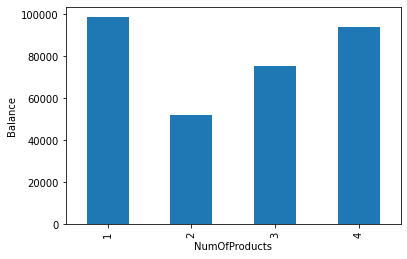

In [21]:
BalanceNumOfProducts = data.groupby('NumOfProducts')['Balance'].mean()
BalanceNumOfProducts = BalanceNumOfProducts.plot.bar()
BalanceNumOfProducts.set_ylabel("Balance")

### NumOfProducts to Exited

Text(0, 0.5, 'Exited')

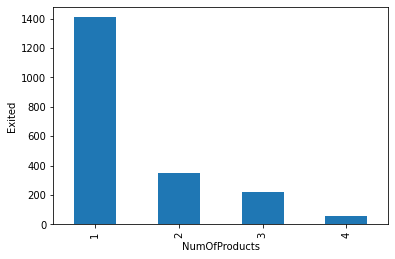

In [22]:
NumOfProductsExited = data.groupby('NumOfProducts')['Exited'].sum()
NumOfProductsExited = NumOfProductsExited.plot.bar()
NumOfProductsExited.set_ylabel("Exited")

### Age to Exited

Text(0, 0.5, 'Exited')

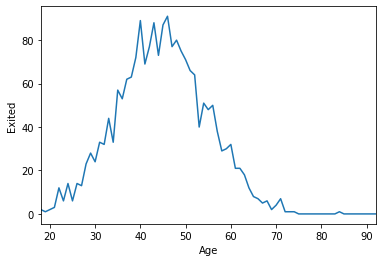

In [23]:
AgeExited = data.groupby('Age')['Exited'].sum()
AgeExited = AgeExited.plot.line()
AgeExited.set_ylabel("Exited")

### Country to Balance

Text(0, 0.5, 'Exited')

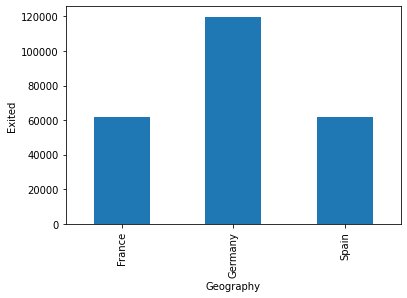

In [29]:
ogdata = pd.read_csv('data/Churn_Modelling.csv')
countryBalance = ogdata.groupby('Geography')['Balance'].mean()
countryBalance = countryBalance.plot.bar()
countryBalance.set_ylabel("Exited")

### Country to Exited

Text(0, 0.5, 'Exited')

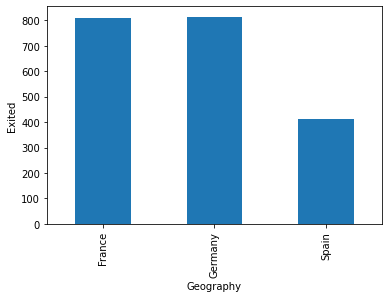

In [25]:
countryExited = ogdata.groupby('Geography')['Exited'].sum()
countryExited = countryExited.plot.bar()
countryExited.set_ylabel("Exited")

## 3) Division of the records into a training group and a test group

In [26]:
y = data.Exited.values
x_data = data.drop(['Exited'], axis=1)

### Normalizing the Data

In [32]:
x = x_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled, columns=x_data.columns)
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_dummy_France,Geo_dummy_Germany,Geo_dummy_Spain
0,0.538,0.0,0.324324,0.2,0.000000,0.000000,1.0,1.0,0.506735,1.0,0.0,0.0
1,0.516,0.0,0.310811,0.1,0.334031,0.000000,0.0,1.0,0.562709,0.0,0.0,1.0
2,0.304,0.0,0.324324,0.8,0.636357,0.666667,1.0,0.0,0.569654,1.0,0.0,0.0
3,0.698,0.0,0.283784,0.1,0.000000,0.333333,0.0,0.0,0.469120,1.0,0.0,0.0
4,1.000,0.0,0.337838,0.2,0.500246,0.000000,1.0,1.0,0.395400,0.0,0.0,1.0


In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (8000, 12)
y_train shape:  (8000,)
x_test shape:  (2000, 12)
y_test shape:  (2000,)


## 4) Models training and evaluation.

### KNN

In [39]:
# Defining the model with a k number of 13:
knn = KNeighborsClassifier(n_neighbors=13)

# Training the model:
knn.fit(x_train, y_train)

# Predicting target values by using x_test and our model:
y_pred1 = knn.predict(x_test)

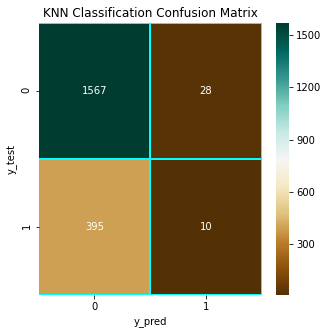

In [40]:
# Creating the confusion matrix:
knn_cm = confusion_matrix(y_test, y_pred1)

# Visualization:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(knn_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='BrBG')
plt.title('KNN Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [41]:
score_knn = knn.score(x_test, y_test)
print(score_knn)

0.7885


### Random Forest

In [43]:
# Defining:
rf = RandomForestClassifier(n_estimators=100, random_state=3)

# Training:
rf.fit(x_train, y_train)

# Predicting:
y_pred5 = rf.predict(x_test)

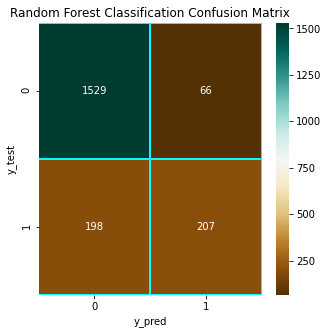

In [44]:
# Creating the confusion matrix:
rf_cm = confusion_matrix(y_test, y_pred5)

# Visualization:
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(rf_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='BrBG')
plt.title('Random Forest Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [45]:
score_rf = rf.score(x_test, y_test)
print(score_rf)

0.868


### Comparing the Classification Algorithms